In [1]:
#Update pyglet library
# !pip install pyglet==1.2.4

In [2]:
import sys
from gym.wrappers import Monitor
import gym
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import model_from_json


Using TensorFlow backend.


### Display the environment

In [3]:
import os
directory_model = 'save_model'
directory_graph = 'save_graph'

#directory = 'save_graph'
if not os.path.exists(directory_model):
    os.makedirs(directory_model)

if not os.path.exists(directory_graph):
    os.makedirs(directory_graph)    

Defining the maximum number of episodes

In [4]:
EPISODES = 1000

## Steps to follow to train the model

Set the values of the hyperparameter and initialize the neural network model through the command
```python
agent = DQNAgent(state_size, action_size)
```

### Hyperparameters

- discount_factor: discount factor gamma
- learning_rate: learning rate of the model
- epsilon: Initial value of ε for ε-greedy policy
- epsilon_decay: Decay rate of ε
- epsilon_min: Minimum value of ε. Cannot decay beyound this value
- batch_size: Batch size to train the network
- train_start: Minimum samples required in memory to start training the network
- memory : deque(maxlen=1000) : Size of the memory to store samples 

 

### Training the model

We know the update policy for Q-learning as:
$Q_{t} (S_{t}, a) = Q_{t}  (S_{t}, a) + \alpha (R_{t+1} + \gamma *  \max\limits_a  Q_{t}(S_{t+1}, a) - Q_{t} (S_{t}, a)]$


$Target : reward + (discount  \: Factor) * (max(next \: Q \: value))$
 

Finally, we will train the model 


In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        # If you want to see Cartpole learning, then change to True
        self.render = True
        self.load_model = False

        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.91
        self.learning_rate = 0.001
        
        
        self.epsilon = 1.0
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.01
        
        self.batch_size = 32
        self.train_start = 500
        
        # create replay memory using deque
        self.memory = deque(maxlen=3000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()
        
        #self.save_model_graph()

        #if self.load_model:
#         self.model.load_weights("./save_model/cartpole_dqn.h5")
#         self.epsilon = 0.0

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        '''
        TODO:
        Build multilayer perceptron to train the Q(s,a) function. In this neural network, the input will be states and the output 
        will be Q(s,a) for each (state,action). 
        Note: Since the ouput Q(s,a) is not restricted from 0 to 1, we use 'linear activation' as output layer.

        Loss Function:
        Loss=1/2 * (R_t + γ∗max Q_t (S_{t+1},a)−Q_t(S_t,a)^2
               which is 'mean squared error'

        '''
        
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def save_model_graph(self):
        # serialize model to JSON
        model_json = self.model.to_json()
        with open("./save_model/cartpole_dqn_model.json", "w") as json_file:
            json_file.write(model_json)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        '''
        TODO:
        Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
        biases of target Q-value network will become same as current Q-value network.
        '''
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        '''
        Select action
        Args:
            state: At any given state, choose action
        
        TODO:
        Choose action according to ε-greedy policy. We generate a random number over [0, 1) from uniform distribution.
        If the generated number is less than ε, we will explore, otherwise we will exploit the policy by choosing the
        action which has maximum Q-value.
        
        More the ε value, more will be exploration and less exploitation.
        
        '''
        # choose random action if generated random number is less than ε.
        # Action is represented by index, 0-Number of actions, like (0,1,2,3) for 4 actions
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        '''
        Save sample in memory and decay ε after we generate each sample from environment. 
        
        Args:
            (state, action, reward, next_state, done)- <s,a,r,s',done> 
        
        TODO:
            We are saving each sample  (state, action, reward, next_state, done) of the episode, in a memory. Memory can be 
            defined by queue. We will dequeue sample of batch size from the memory and use it to train the neural network.
            
            ε-decay:
            With ε, we explore and with 1-ε, we exploit. Initially we want to explore more, but at later point, after training 
            the model, we have good policy to choose better action. So, at that point, we want to expoit more and explore less.
            So, we want to decrease the value of ε, by which we explore. 
            
            self.epsilon_min:
            Minimum value of ε, by which we want to explore. If the current value of ε is greater then 
            minimum value to ε, we will decay ε gradually, when generating samples. 
            
            Note: The rate by which we will decrease ε should be slow, otherwise we will not explore much and instead settle
            for suboptimal policy instead of optiomal policy. 
    
        '''
        # Adding sample to the memory. 
        self.memory.append((state, action, reward, next_state, done))
        
        # Decay in ε after we generate each sample from the environment
        self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        '''
        Train the neural network to find the best policy
        
        TODO:
        1. Sample <s,a,r,s',done> of batch size from the memory
        2. Set the target as R_t + γ∗max Q_t(S_{t+1},a)−Q_t(S_t,a)
        3. Set the target only for the action we took in the environment. For the other actions, we don't wan't to 
        update the network. 
        4. Remember that we already the actions that we took when generating sample from environment
        4. To find the Q_t(S_{t+1},a), we input the next state s' to the model, and we get Q-value for all the actions
        5. To find the Q_t(S_t,a), we input the current state s to the model, and we get Q-value for all the actions
        6. Train the model
        
        Note:
        We use 2 different neural network for Q_t(S_t,a) and target Q_t(S_{t+1},a). This is so because we are 
        constantly updating the current Q-value network at each and every timestep in a episode. Therefore, the target 
        Q-value will change subsequently. The network can become destabilized by falling into feedback loops between the
        target and current Q-values.
        We update the target Q-value network only after completion of a batch. We update the target Q-value with the 
        current Q-value network. 
        
        '''
        # We start the training only when we have sufficient sample in the memory. We set the number of samples required
        # start training in variable train_start
        if len(self.memory) < self.train_start:
            return
        
        # Sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)
     
        # Initialise the variables update_input and update_target for a batch for storing the s and s'.
        # Later, we will use it to store Q_t(S_t,a_t) and Q_t(S_{t+1},a)
        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done> 
        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        # Set the target as Q values predicted from the current state and next state 
        # store Q_t(S_t,a_t) and Q_t(S_{t+1},a) in target and target_val
        target = self.model.predict(update_input)
        target_val = self.target_model.predict(update_target)
        
        
        # Update the target value according to the update policy of Q-learning
        # R_t + γ ∗ max Q_t(S_{t+1},a)−Q_t(S_t,a_t)
        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)


### Main function
Here, we will generate samples <s, a, r, s'> in episodes using the environment. Save these samples in memory and train the model.
If the mean of scores of last 30 episode is bigger than 490 stop training.

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 1,476
Trainable params: 1,476
Non-trainable params: 0
_________________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6

episode: 42   score: -57.7239   time_steps: 65  landing_ops_time: 0   landing_coord: (0.0595, -0.0428)  epsilon: 0.6974
episode: 43   score: -148.9137   time_steps: 101  landing_ops_time: 0   landing_coord: (0.5724, 0.0686)  epsilon: 0.6904
episode: 44   score: -89.7979   time_steps: 58  landing_ops_time: 0   landing_coord: (-0.4012, 0.0768)  epsilon: 0.6865
episode: 45   score: -0.3326   time_steps: 82  landing_ops_time: 0   landing_coord: (-0.026, -0.0428)  epsilon: 0.681
episode: 46   score: -109.9019   time_steps: 113  landing_ops_time: 0   landing_coord: (0.6142, 0.0548)  epsilon: 0.6734
episode: 47   score: -68.6323   time_steps: 73  landing_ops_time: 0   landing_coord: (-0.3401, 0.0434)  epsilon: 0.6686
episode: 48   score: -35.5505   time_steps: 71  landing_ops_time: 0   landing_coord: (-0.2093, -0.0303)  epsilon: 0.6639
episode: 49   score: -139.76   time_steps: 75  landing_ops_time: 0   landing_coord: (0.3739, -0.0192)  epsilon: 0.659
episode: 50   score: -118.3558   time_ste

episode: 109   score: -330.6591   time_steps: 158  landing_ops_time: 127.4   landing_coord: (-0.6381, 0.1699)  epsilon: 0.3425
episode: 110   score: -38.1344   time_steps: 75  landing_ops_time: 131.8   landing_coord: (0.4917, 0.1146)  epsilon: 0.34
episode: 111   score: -5.6415   time_steps: 85  landing_ops_time: 115.0   landing_coord: (0.2852, -0.0097)  epsilon: 0.3371
episode: 112   score: -449.2371   time_steps: 292  landing_ops_time: 113.6   landing_coord: (0.3425, -0.0689)  epsilon: 0.3275
episode: 113   score: -1042.2438   time_steps: 411  landing_ops_time: 124.6   landing_coord: (0.1168, -0.0359)  epsilon: 0.3143
episode: 114   score: -73.0946   time_steps: 71  landing_ops_time: 160.0   landing_coord: (0.4329, -0.1832)  epsilon: 0.3121
episode: 115   score: -36.7464   time_steps: 101  landing_ops_time: 129.0   landing_coord: (-0.2732, 0.0296)  epsilon: 0.309
episode: 116   score: -84.2464   time_steps: 64  landing_ops_time: 127.2   landing_coord: (-0.4263, -0.0482)  epsilon: 0.3

episode: 175   score: -52.8396   time_steps: 110  landing_ops_time: 264.4   landing_coord: (0.5832, -0.0094)  epsilon: 0.0757
episode: 176   score: -19.2624   time_steps: 95  landing_ops_time: 269.0   landing_coord: (-0.6841, -0.1223)  epsilon: 0.075
episode: 177   score: -203.1055   time_steps: 301  landing_ops_time: 233.6   landing_coord: (-0.6874, -0.2177)  epsilon: 0.0728
episode: 178   score: -61.0255   time_steps: 145  landing_ops_time: 256.2   landing_coord: (-0.4151, 0.1118)  epsilon: 0.0718
episode: 179   score: -12.3179   time_steps: 191  landing_ops_time: 230.8   landing_coord: (-0.1433, -0.033)  epsilon: 0.0704
episode: 180   score: -156.7168   time_steps: 236  landing_ops_time: 149.8   landing_coord: (0.6499, 0.068)  epsilon: 0.0688
episode: 181   score: -83.3366   time_steps: 155  landing_ops_time: 131.8   landing_coord: (-0.4392, -0.0095)  epsilon: 0.0677
episode: 182   score: -2239.8671   time_steps: 583  landing_ops_time: 137.2   landing_coord: (0.3639, 0.0056)  epsilo

episode: 240   score: -2582.2964   time_steps: 797  landing_ops_time: 373.7   landing_coord: (0.2735, 0.0208)  epsilon: 0.0064
episode: 241   score: -35.0196   time_steps: 94  landing_ops_time: 368.7   landing_coord: (0.4466, -0.0768)  epsilon: 0.0063
episode: 242   score: 296.2806   time_steps: 253  landing_ops_time: 341.2   landing_coord: (-0.0339, -0.0006)  epsilon: 0.0062
episode: 243   score: -24.2485   time_steps: 83  landing_ops_time: 299.7   landing_coord: (-0.3184, 0.0413)  epsilon: 0.0061
episode: 244   score: -1663.4875   time_steps: 572  landing_ops_time: 301.6   landing_coord: (0.4455, 0.0541)  epsilon: 0.0058
episode: 245   score: -574.1717   time_steps: 448  landing_ops_time: 351.8   landing_coord: (0.2336, 0.0373)  epsilon: 0.0055
episode: 246   score: -154.2729   time_steps: 138  landing_ops_time: 348.2   landing_coord: (-0.2971, -0.0236)  epsilon: 0.0055
episode: 247   score: -84.0211   time_steps: 72  landing_ops_time: 319.3   landing_coord: (-0.524, -0.1583)  epsilo

episode: 306   score: -60.5776   time_steps: 252  landing_ops_time: 301.2   landing_coord: (0.3326, -0.1238)  epsilon: 0.0011
episode: 307   score: -462.749   time_steps: 323  landing_ops_time: 317.2   landing_coord: (-0.9494, -0.3579)  epsilon: 0.001
episode: 308   score: -209.7368   time_steps: 97  landing_ops_time: 291.0   landing_coord: (0.2116, 0.0026)  epsilon: 0.001
episode: 309   score: -2116.5327   time_steps: 592  landing_ops_time: 292.2   landing_coord: (0.8214, -0.0604)  epsilon: 0.001
episode: 310   score: -214.0102   time_steps: 287  landing_ops_time: 322.1   landing_coord: (-0.6134, 0.0608)  epsilon: 0.0009
episode: 311   score: -672.6297   time_steps: 371  landing_ops_time: 321.9   landing_coord: (-1.0026, 1.0345)  epsilon: 0.0009
episode: 312   score: -607.1987   time_steps: 377  landing_ops_time: 340.5   landing_coord: (-0.8358, -0.2318)  epsilon: 0.0009
episode: 313   score: -30.3291   time_steps: 66  landing_ops_time: 357.3   landing_coord: (0.474, -0.0341)  epsilon

episode: 371   score: -4692.5545   time_steps: 1001  landing_ops_time: 312.4   landing_coord: (-0.3133, 0.72)  epsilon: 0.0001
episode: 372   score: -72.8167   time_steps: 71  landing_ops_time: 366.7   landing_coord: (0.505, 0.0393)  epsilon: 0.0001
episode: 373   score: -357.0753   time_steps: 111  landing_ops_time: 322.5   landing_coord: (-0.0635, 0.0142)  epsilon: 0.0001
episode: 374   score: -297.4469   time_steps: 131  landing_ops_time: 233.5   landing_coord: (0.0521, 0.0174)  epsilon: 0.0001
episode: 375   score: -127.1716   time_steps: 121  landing_ops_time: 229.0   landing_coord: (-0.135, 0.006)  epsilon: 0.0001
episode: 376   score: -108.1989   time_steps: 196  landing_ops_time: 216.2   landing_coord: (0.7249, -0.2827)  epsilon: 0.0001
episode: 377   score: -20.2641   time_steps: 151  landing_ops_time: 221.7   landing_coord: (0.9779, 0.0799)  epsilon: 0.0001
episode: 378   score: -45.2533   time_steps: 220  landing_ops_time: 230.4   landing_coord: (0.5488, 0.0648)  epsilon: 0.

episode: 437   score: 87.5772   time_steps: 313  landing_ops_time: 418.4   landing_coord: (0.604, -0.1564)  epsilon: 0.0
episode: 438   score: 185.0948   time_steps: 294  landing_ops_time: 386.0   landing_coord: (0.6859, -0.0584)  epsilon: 0.0
episode: 439   score: 191.7304   time_steps: 281  landing_ops_time: 359.0   landing_coord: (0.2773, 0.019)  epsilon: 0.0
episode: 440   score: 176.4644   time_steps: 186  landing_ops_time: 368.5   landing_coord: (0.7789, -0.0246)  epsilon: 0.0
episode: 441   score: 175.9209   time_steps: 324  landing_ops_time: 355.6   landing_coord: (0.1122, -0.0008)  epsilon: 0.0
episode: 442   score: -3785.1536   time_steps: 913  landing_ops_time: 371.0   landing_coord: (0.482, 0.0471)  epsilon: 0.0
episode: 443   score: -4513.4337   time_steps: 1001  landing_ops_time: 362.2   landing_coord: (0.2012, -0.0007)  epsilon: 0.0
episode: 444   score: -4637.9831   time_steps: 1001  landing_ops_time: 449.8   landing_coord: (-0.4205, -0.1125)  epsilon: 0.0
episode: 445 

episode: 504   score: -56.1898   time_steps: 81  landing_ops_time: 190.5   landing_coord: (0.5298, 0.1951)  epsilon: 0.0
episode: 505   score: -236.0711   time_steps: 122  landing_ops_time: 190.8   landing_coord: (-0.3143, -0.0524)  epsilon: 0.0
episode: 506   score: -116.0478   time_steps: 115  landing_ops_time: 190.5   landing_coord: (1.0022, 0.2527)  epsilon: 0.0
episode: 507   score: -1430.9094   time_steps: 510  landing_ops_time: 190.1   landing_coord: (0.0965, -0.0007)  epsilon: 0.0
episode: 508   score: -128.4753   time_steps: 134  landing_ops_time: 229.8   landing_coord: (0.9868, -0.0041)  epsilon: 0.0
episode: 509   score: 209.4923   time_steps: 232  landing_ops_time: 195.1   landing_coord: (-0.1223, -1e-04)  epsilon: 0.0
episode: 510   score: -1867.2492   time_steps: 542  landing_ops_time: 193.6   landing_coord: (0.734, 0.1651)  epsilon: 0.0
episode: 511   score: -214.3992   time_steps: 248  landing_ops_time: 239.2   landing_coord: (-0.2696, -0.0265)  epsilon: 0.0
episode: 51

episode: 571   score: 59.2315   time_steps: 75  landing_ops_time: 232.8   landing_coord: (-0.0218, -0.0374)  epsilon: 0.0
episode: 572   score: -43.6833   time_steps: 92  landing_ops_time: 206.9   landing_coord: (-0.338, 0.0031)  epsilon: 0.0
episode: 573   score: -103.8896   time_steps: 172  landing_ops_time: 204.2   landing_coord: (1.0025, 0.455)  epsilon: 0.0
episode: 574   score: -203.2241   time_steps: 112  landing_ops_time: 206.9   landing_coord: (1.0045, 0.3623)  epsilon: 0.0
episode: 575   score: -2964.3147   time_steps: 745  landing_ops_time: 209.4   landing_coord: (0.2619, 0.0237)  epsilon: 0.0
episode: 576   score: -119.6929   time_steps: 166  landing_ops_time: 247.7   landing_coord: (1.0052, 0.7363)  epsilon: 0.0
episode: 577   score: -141.6191   time_steps: 264  landing_ops_time: 256.2   landing_coord: (1.0024, 0.694)  epsilon: 0.0
episode: 578   score: -36.5917   time_steps: 143  landing_ops_time: 210.1   landing_coord: (-0.1396, -0.039)  epsilon: 0.0
episode: 579   score

episode: 638   score: -39.6799   time_steps: 82  landing_ops_time: 429.0   landing_coord: (0.5129, -0.0049)  epsilon: 0.0
episode: 639   score: -50.2254   time_steps: 142  landing_ops_time: 351.4   landing_coord: (-0.552, 0.1972)  epsilon: 0.0
episode: 640   score: -142.7486   time_steps: 75  landing_ops_time: 357.7   landing_coord: (-0.7522, -0.1441)  epsilon: 0.0
episode: 641   score: -663.0469   time_steps: 426  landing_ops_time: 265.1   landing_coord: (-0.4324, -0.0548)  epsilon: 0.0
episode: 642   score: -139.9019   time_steps: 161  landing_ops_time: 288.1   landing_coord: (1.0025, 0.6454)  epsilon: 0.0
episode: 643   score: -103.8625   time_steps: 101  landing_ops_time: 248.0   landing_coord: (0.8179, 0.125)  epsilon: 0.0
episode: 644   score: -1412.7339   time_steps: 517  landing_ops_time: 214.8   landing_coord: (0.2092, 0.0231)  epsilon: 0.0
episode: 645   score: -826.7647   time_steps: 439  landing_ops_time: 245.9   landing_coord: (0.4812, -0.1249)  epsilon: 0.0
episode: 646  

episode: 705   score: -255.4014   time_steps: 81  landing_ops_time: 193.3   landing_coord: (0.7467, -0.0199)  epsilon: 0.0
episode: 706   score: -229.2969   time_steps: 84  landing_ops_time: 186.3   landing_coord: (1.0125, -0.1723)  epsilon: 0.0
episode: 707   score: -716.6625   time_steps: 347  landing_ops_time: 176.6   landing_coord: (1.003, 1.1592)  epsilon: 0.0
episode: 708   score: -383.5306   time_steps: 96  landing_ops_time: 161.2   landing_coord: (-1.002, 0.3044)  epsilon: 0.0
episode: 709   score: -131.3661   time_steps: 65  landing_ops_time: 164.2   landing_coord: (0.6159, 0.1472)  epsilon: 0.0
episode: 710   score: -217.5995   time_steps: 173  landing_ops_time: 159.5   landing_coord: (1.0015, 1.4343)  epsilon: 0.0
episode: 711   score: -428.5613   time_steps: 296  landing_ops_time: 165.8   landing_coord: (1.0022, 0.8997)  epsilon: 0.0
episode: 712   score: -139.2414   time_steps: 104  landing_ops_time: 175.9   landing_coord: (0.9394, -0.1327)  epsilon: 0.0
episode: 713   sco

episode: 772   score: -22.6396   time_steps: 110  landing_ops_time: 153.5   landing_coord: (-0.3462, 0.085)  epsilon: 0.0
episode: 773   score: -221.3758   time_steps: 88  landing_ops_time: 146.6   landing_coord: (-1.0034, -0.013)  epsilon: 0.0
episode: 774   score: -182.729   time_steps: 99  landing_ops_time: 148.5   landing_coord: (1.0011, 1.1346)  epsilon: 0.0
episode: 775   score: 293.8851   time_steps: 134  landing_ops_time: 143.3   landing_coord: (-0.0033, -0.0014)  epsilon: 0.0
episode: 776   score: -221.3547   time_steps: 88  landing_ops_time: 120.6   landing_coord: (-1.0031, -0.1604)  epsilon: 0.0
episode: 777   score: -395.2843   time_steps: 198  landing_ops_time: 103.9   landing_coord: (-0.5376, -0.0919)  epsilon: 0.0
episode: 778   score: -593.8922   time_steps: 325  landing_ops_time: 116.7   landing_coord: (1.0007, 1.0364)  epsilon: 0.0
episode: 779   score: -1919.7513   time_steps: 573  landing_ops_time: 140.8   landing_coord: (-0.3756, -0.0458)  epsilon: 0.0
episode: 780

episode: 839   score: -228.9394   time_steps: 90  landing_ops_time: 219.2   landing_coord: (1.0072, 0.4689)  epsilon: 0.0
episode: 840   score: -257.9387   time_steps: 199  landing_ops_time: 218.1   landing_coord: (0.5522, -0.1447)  epsilon: 0.0
episode: 841   score: -271.5518   time_steps: 190  landing_ops_time: 226.6   landing_coord: (-0.7282, -0.0676)  epsilon: 0.0
episode: 842   score: -24.1381   time_steps: 73  landing_ops_time: 221.5   landing_coord: (0.2312, -0.0533)  epsilon: 0.0
episode: 843   score: -137.8609   time_steps: 151  landing_ops_time: 218.3   landing_coord: (1.0049, 0.2608)  epsilon: 0.0
episode: 844   score: 155.7516   time_steps: 252  landing_ops_time: 211.4   landing_coord: (0.0848, -0.0009)  epsilon: 0.0
episode: 845   score: -140.0695   time_steps: 185  landing_ops_time: 224.0   landing_coord: (0.9908, -0.2572)  epsilon: 0.0
episode: 846   score: -352.3984   time_steps: 361  landing_ops_time: 192.5   landing_coord: (-0.0706, -0.0012)  epsilon: 0.0
episode: 847

episode: 906   score: -135.9998   time_steps: 212  landing_ops_time: 331.6   landing_coord: (-0.2262, -0.0192)  epsilon: 0.0
episode: 907   score: -62.9931   time_steps: 81  landing_ops_time: 341.8   landing_coord: (-0.7212, -0.0922)  epsilon: 0.0
episode: 908   score: 45.2956   time_steps: 75  landing_ops_time: 328.1   landing_coord: (-0.079, -0.0428)  epsilon: 0.0
episode: 909   score: -95.3496   time_steps: 249  landing_ops_time: 235.5   landing_coord: (0.1211, -0.0428)  epsilon: 0.0
episode: 910   score: -131.591   time_steps: 141  landing_ops_time: 225.0   landing_coord: (-1.0019, 0.4858)  epsilon: 0.0
episode: 911   score: -211.7086   time_steps: 194  landing_ops_time: 229.5   landing_coord: (1.0036, 0.0014)  epsilon: 0.0
episode: 912   score: -142.0384   time_steps: 218  landing_ops_time: 188.8   landing_coord: (-0.5669, 0.0302)  epsilon: 0.0
episode: 913   score: 29.7254   time_steps: 68  landing_ops_time: 163.6   landing_coord: (-0.0097, -0.0428)  epsilon: 0.0
episode: 914   s

episode: 973   score: -292.4656   time_steps: 98  landing_ops_time: 159.8   landing_coord: (1.0166, 0.0208)  epsilon: 0.0
episode: 974   score: -45.5007   time_steps: 209  landing_ops_time: 161.1   landing_coord: (-0.2856, -0.0395)  epsilon: 0.0
episode: 975   score: -152.7276   time_steps: 101  landing_ops_time: 169.2   landing_coord: (0.6813, 0.098)  epsilon: 0.0
episode: 976   score: -61.1413   time_steps: 237  landing_ops_time: 166.4   landing_coord: (-0.065, -0.0335)  epsilon: 0.0
episode: 977   score: -3.4195   time_steps: 168  landing_ops_time: 168.6   landing_coord: (-0.2087, -0.0403)  epsilon: 0.0
episode: 978   score: 25.9444   time_steps: 320  landing_ops_time: 165.0   landing_coord: (-0.0753, -0.0009)  epsilon: 0.0
episode: 979   score: -90.4857   time_steps: 131  landing_ops_time: 187.7   landing_coord: (0.619, 0.0307)  epsilon: 0.0
episode: 980   score: -101.5585   time_steps: 69  landing_ops_time: 190.6   landing_coord: (-0.6514, 0.1684)  epsilon: 0.0
episode: 981   scor

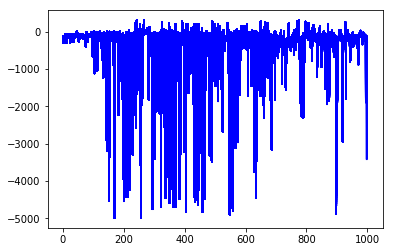

In [6]:
'''
TODO:
    1. Generate multiple epoisdes 
    2. At each timestep in a episode, store the sample <s, a, r, s',done> and save it in memory. Then, take a random batch
    of batch size from the memory and train the network.
    3. Take action according to the ε-greedy policy and go the next state. 
    4. Update the current Q-value network after every timestep in a episode.  
    5. Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
    biases of target Q-value network will become same as current Q-value network.
    
Note: Penalty of -100 is added if an action make the episode end.
    
'''

if __name__ == "__main__":
      
    
    env = Monitor(gym.make('LunarLander-v2'), './video/',video_callable=lambda episode_id: True,force = True)
    
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes, time_step = [], [], []

    for e in range(EPISODES+1):
        done = False
        score = 0
        state = env.reset()
        

        state = np.reshape(state, [1, state_size])
        time=1
        landing_ops_time=0
        
        while not done:
            if agent.render:
                env.render()
            time+=1
            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            if(time<30):
                action=0
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            if(time >300):
                reward-=5
            
            
            
            if((len(time_step) >50)):
                landing_ops_time=(np.mean(time_step[:-11:-1])-20)
                if(time >landing_ops_time):

                    if (next_state[0][3] - state[0][3] >0)  | (next_state[0][2] - state[0][2]>0) | (next_state[0][5] - state[0][5]>0):
                        reward-=2
                    else:
                        reward+=2
# ----                        

#                     if ((next_state[0][0] <.02)|(next_state[0][1] <.02))|((next_state[0][0] >0.02)|(next_state[0][1] >0.02)) :
#                         reward-=5
#                     else:
#                         reward+=5
    #                 if(action !=0):
    #                     reward-=3
    #                 else:
    #                     reward+=3

            # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 200 else -100
#             print(state)
#             print(next_state)
#             if (next_state[0][0] - state[0][0] >0)  & (next_state[0][1] - state[0][1]>0) :
#                 reward-=3
#             else:
#                 reward+=3

            
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            
            # every time step do the training
            agent.train_model()
            
            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()
                time_step.append(time)

                

                if ((next_state[0][0] <-.02)|(next_state[0][1] <-.02))|((next_state[0][0] >0.02)|(next_state[0][1] >0.02)) :
                    reward-=30
                else:
                    if (time <250) :
                        reward+=70
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", round(score,4), "  time_steps:",
                      time," landing_ops_time:",round(landing_ops_time,4) ,"  landing_coord:",(round(next_state[0][0],4),round(next_state[0][1],4))," epsilon:", round(agent.epsilon,4))

                # if the mean of scores of last 30 episode is bigger than 490
                # stop training
#                 if np.mean(scores[-min(30, len(scores)):]) > 490:
                agent.model.save_weights("./save_model/cartpole_dqn.h5")
#                     sys.exit()
        #save the model 
        if e % 50 == 0:
            agent.model.save_weights("./save_model/cartpole_dqn.h5")
            
env.close()       

In [10]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
score = 0
state = env.reset()
state = np.reshape(state, [1, state_size])
done = False

# Run the model for single episode
while not done:
    # env.render()
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    score += reward
    
print('Score is ', score)
env.close()   
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 132       
Total params: 1,476
Trainable params: 1,476
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18

In [8]:
# the state vector consists of eight variables (in this order) between -1 and 1:

# Lander position in x
# Lander position in y
# Lander velocity in x
# Lander velocity in y
# Lander angle
# Lander angular velocity
# Contact left landing leg
# Contact right landing leg


In [9]:
# t=[2,4,3,26,33,55,23,55,12]
# t[:-:-1]

SyntaxError: invalid syntax (<ipython-input-9-79dd11ab2b8c>, line 2)